In [2]:
import time
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import ccf
from scipy.signal import fftconvolve

# NN model definition

In [3]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t.squeeze(1), (h_t, c_t))
            output = self.linear(h_t)

            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            if output.dim()<3:
                output=output.unsqueeze(1)
            h_t, c_t = self.lstm(output.squeeze(1), (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1)
        return outputs


In [4]:
class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=100,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []
            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)
            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) // 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

# Load and clean data

In [5]:
# aux method to parse the date information we have in the df correctly
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

df = pd.read_csv("../datasets/AirPollution.csv", parse_dates = [["year", "month", "day", "hour"]], 
                 index_col=0, date_parser=parse)
df.drop("No", axis=1, inplace=True) # Drop the No column, we don't need it
df.columns = ["pollution", "dew", "temp", "press", "wnd_dir", "wnd_spd", "snow", "rain"] # better column names
df.index.name = "date" # rename index
df.pollution.fillna(0, inplace=True) # replace NaN pollution values with 0s
df = df[24:] # First hour of information is removed since all entries were NaN values
df.to_csv("../datasets/cleanPollutionData.csv") # Save the clean and pre-processed data
df.head(10)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


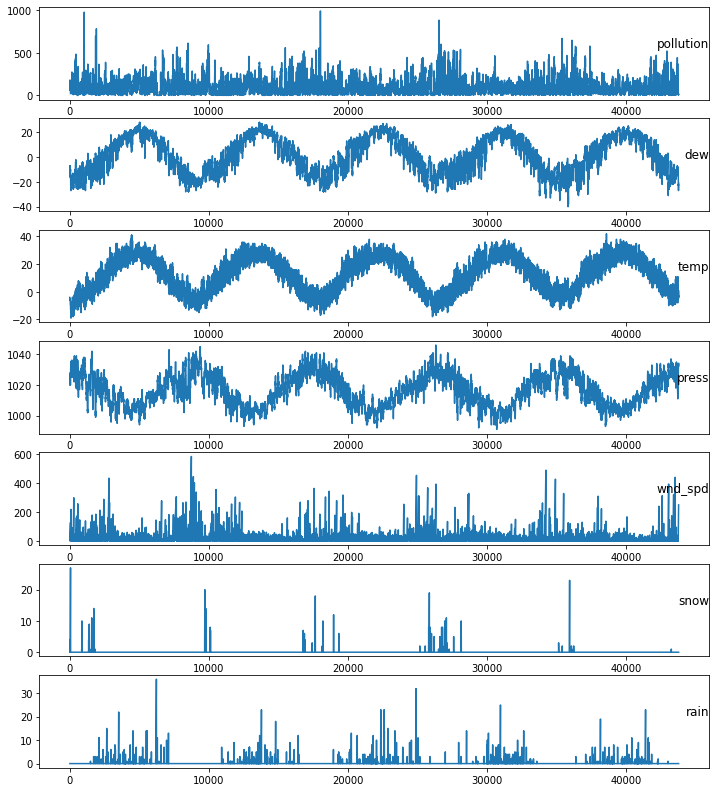

In [5]:
# Plot the data to see what we are working with
values = df.values
cols_to_plot = [0,1,2,3,5,6,7] # We won't be using the categorical variable wind_dir
i=1
plt.figure(figsize=(12,14))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(values[:, col])
    plt.title(df.columns[col], y=0.5, loc="right")
    i += 1
plt.show()

# Preparing data for the LSTM Network

In [6]:
# Perform train-test split
test_length = 0.2
split_index = int(df.shape[0]*test_length)
train = df[:-split_index]
test = df[-split_index:]

In [7]:
# Divide the index data into separate features (we can use year, month, day for prediction)
tr_year = train.index.year
te_year = test.index.year

tr_month = train.index.month
te_month = test.index.month

tr_day = train.index.day
te_day = test.index.day

# Build the full training and testing dataframes
tr_df_denorm = pd.DataFrame({
    "pollution": train.values[:,0], 
    "dew": train.values[:,1], 
    "temp": train.values[:,2], 
    "press": train.values[:,3], 
    "wnd_spd": train.values[:,5], 
    "snow": train.values[:,6], 
    "rain": train.values[:,7],
    "year": tr_year.values,
    "month": tr_month.values,
    "day": tr_day.values
}, index=train.index.values, dtype=np.float32, columns=["pollution", "dew", "temp", "press", "wnd_spd", "snow", "rain", "year", "month", "day"])


te_df_denorm = pd.DataFrame({
    "pollution": test.values[:,0], 
    "dew": test.values[:,1], 
    "temp": test.values[:,2], 
    "press": test.values[:,3], 
    "wnd_spd": test.values[:,5], 
    "snow": test.values[:,6], 
    "rain": test.values[:,7],
    "year": te_year.values,
    "month": te_month.values,
    "day": te_day.values
}, index=test.index.values, dtype=np.float32, columns=["pollution", "dew", "temp", "press", "wnd_spd", "snow", "rain", "year", "month", "day"])

# In order to pass the data to the LSTM we need to transform it so it is in the range [-1,1]
# We scale all our data in order to build the final training and test dataframes

tr_df = tr_df_denorm
te_df = te_df_denorm
for col in tr_df.columns:
    # mean std Z standardization
    mean = tr_df_denorm[col].values.mean()
    std = tr_df_denorm[col].values.std()
    tr_df[col] = (tr_df_denorm[col].values-mean)/std
    te_df[col] = (te_df_denorm[col].values-mean)/std
    
# Preview of the final versions
print(tr_df.head())
print()
print(te_df.head())

                     pollution       dew      temp     press   wnd_spd      snow      rain      year     month       day
2010-01-02 00:00:00   0.387788 -1.226144 -1.312594  0.346640 -0.451588 -0.074277 -0.140864 -1.343579 -1.603408 -1.562281
2010-01-02 01:00:00   0.594518 -1.157154 -1.312594  0.346640 -0.434244 -0.074277 -0.140864 -1.343579 -1.603408 -1.562281
2010-01-02 02:00:00   0.714204 -0.881191 -1.393850  0.442923 -0.416900 -0.074277 -0.140864 -1.343579 -1.603408 -1.562281
2010-01-02 03:00:00   0.953575 -0.605228 -1.393850  0.539206 -0.382017  1.218002 -0.140864 -1.343579 -1.603408 -1.562281
2010-01-02 04:00:00   0.485713 -0.605228 -1.393850  0.539206 -0.364673  2.510281 -0.140864 -1.343579 -1.603408 -1.562281

                     pollution       dew      temp     press   wnd_spd      snow      rain      year     month       day
2014-01-01 00:00:00  -0.754666 -1.502107 -0.418784 -0.231058  2.309593 -0.074277 -0.140864  2.236094 -1.603408 -1.675987
2014-01-01 01:00:00  -0.439131 


Correlations:


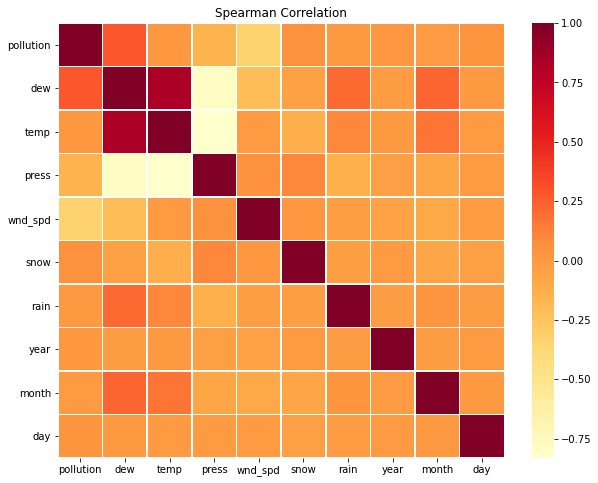

Found an acceptable correlation coefficient for these columns: [0, 1, 3, 4]


In [8]:
# Normal correlation matrix analysis: Spearman Correlation
print("\nCorrelations:")

s_corr = tr_df.corr(method="spearman")
plt.figure(figsize=(10,8))
sns.heatmap(data=s_corr, cmap="YlOrRd", linewidths=.5)
plt.title("Spearman Correlation")
plt.show()

# Extract the columns which display most correlation with the value we are trying to predict
forecast_target_col = 0
corr_threshhold = 0.10
corrmat_row = s_corr.iloc[forecast_target_col, :]
corrmat_row_vals = corrmat_row.values.tolist()
# Get only the columns that have a correlation coefficient > 0.10 or <-0.10
correlated_features = []
for val in corrmat_row_vals:
    if (val > corr_threshhold or val < -corr_threshhold):
        correlated_features.append(corrmat_row_vals.index(val))
print("Found an acceptable correlation coefficient for these columns:", correlated_features)

In [9]:
# From the correlation matrix above we can see that the pollution is mostly 
# correlated with the Dew Point, wind speed and the atmosferic pressure (and of course with itself)
# Those are also the values we extracted automatically from our correlation matrix and the
# values that we will use as training data for the network.
desired_input_features = correlated_features

1
35040 [-0.05736563 -0.05697369 -0.0566551  -0.05632937 -0.05621686 -0.05626673
 -0.05647116 -0.05719748 -0.05797024 -0.05897334]
3
35040 [0.04380714 0.04432609 0.04505235 0.04600342 0.04723136 0.04873775
 0.05026139 0.05158154 0.05227848 0.05251446]
4
35040 [-0.01955314 -0.02250645 -0.02515115 -0.02720598 -0.02932634 -0.03072218
 -0.03176666 -0.03248483 -0.03278246 -0.03287968]


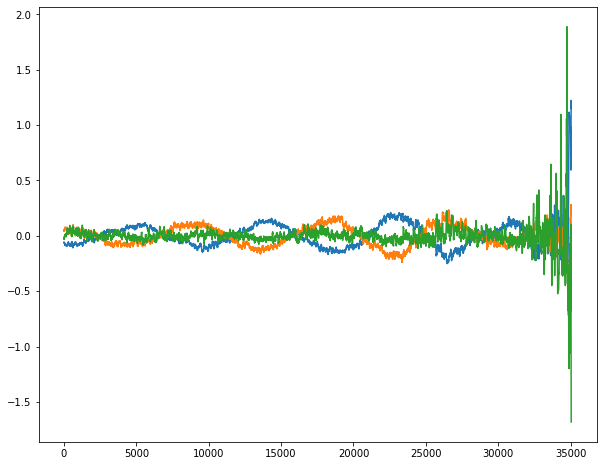

In [37]:
# Adding exogenous data

# The data should be added in the beginning and then we run the network for the 
# correlated features with and without the exogenous data. If the prediction improves
# then we are looking at leading indicator and better forecast accuracy

In [10]:
# Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
# input sequences that will have output sequences which the model will then learn.

# Training
inp_tr = np.stack([tr_df.shift(i).values for i in range(12, 36)], axis=1)[36:, -1::-1, desired_input_features].copy()
out_tr = np.stack([tr_df.shift(i).values for i in range(12)], axis=1)[36:, -1::-1, desired_input_features].copy()
print("Inputs for training")
print(inp_tr.shape)
print("Outputs for training")
print(out_tr.shape)
print("\n")
# Testing
inp_te = np.stack([te_df.shift(i).values for i in range(12, 36)], axis=1)[36:, -1::-1, desired_input_features].copy()
out_te = np.stack([te_df.shift(i).values for i in range(12)], axis=1)[36:, -1::-1, desired_input_features].copy()
print("Inputs for testing")
print(inp_te.shape)
print("Outputs for testing")
print(out_te.shape)

Inputs for training
(35004, 24, 4)
Outputs for training
(35004, 12, 4)


Inputs for testing
(8724, 24, 4)
Outputs for testing
(8724, 12, 4)


In [11]:
# Transform the input and output sequences into PyTorch Tensors in order to feed them to the model
x_train=torch.cat((torch.Tensor(inp_tr),torch.Tensor(out_tr)),1)
x_test=torch.Tensor(inp_te)

# Forecasting with the LSTM Network

In [12]:
# Build the model and set the preferred loss function, optimizer and scheduler
# All this information is then used in the Optimization helper class.
LSTM_Model = Model(input_size=len(desired_input_features), hidden_size=21, output_size=len(desired_input_features))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(LSTM_Model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)
opt_obj = Optimization(LSTM_Model, loss_fn, optimizer, scheduler)

In [13]:
# Train the model on the training data
opt_obj.train(x_train[:,:-1],x_train[:,1:],x_train[:,:-1],x_train[:,1:],do_teacher_forcing=True, n_epochs=15)

Epoch 1 Train loss: 0.51. Validation loss: 0.23. Avg future: 9.41. Elapsed time: 13.12s.
Epoch 2 Train loss: 0.19. Validation loss: 0.13. Avg future: 8.96. Elapsed time: 12.92s.
Epoch 3 Train loss: 0.11. Validation loss: 0.09. Avg future: 9.14. Elapsed time: 13.02s.
Epoch 4 Train loss: 0.08. Validation loss: 0.07. Avg future: 8.97. Elapsed time: 12.94s.
Epoch 5 Train loss: 0.07. Validation loss: 0.06. Avg future: 8.62. Elapsed time: 13.32s.
Epoch 6 Train loss: 0.06. Validation loss: 0.06. Avg future: 8.87. Elapsed time: 12.94s.
Epoch 7 Train loss: 0.06. Validation loss: 0.06. Avg future: 9.34. Elapsed time: 12.95s.
Epoch 8 Train loss: 0.06. Validation loss: 0.06. Avg future: 8.91. Elapsed time: 12.82s.
Epoch 9 Train loss: 0.06. Validation loss: 0.05. Avg future: 9.09. Elapsed time: 12.86s.
Epoch 10 Train loss: 0.06. Validation loss: 0.06. Avg future: 9.10. Elapsed time: 12.52s.
Epoch 11 Train loss: 0.06. Validation loss: 0.05. Avg future: 9.02. Elapsed time: 12.51s.
Epoch 12 Train loss

In [14]:
# Use the model to forecast
pred=LSTM_Model(x_test, 11)

# Results

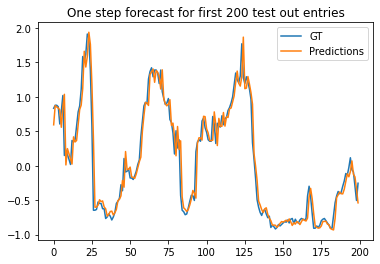

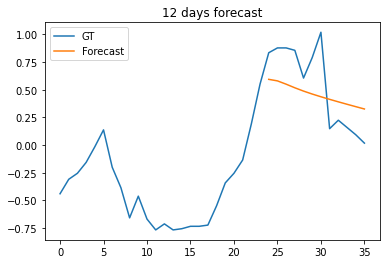

RMSE value: 0.25900155
MAE value: 0.13859236


In [15]:
# Plot the forecast against the output test data that we have

# First we need to rescale the data back to normal to plot the predictions and actual test output
# Since we are interested in the pollution prediction the we can only rescale that during plotting

# At first we calculate the mean and std of the pollution values
poll_mean = np.mean(tr_df_denorm["pollution"].values)
poll_std = np.std(tr_df_denorm["pollution"].values)

plt.title("One step forecast for first 200 test out entries")
plt.plot(range(0,200),out_te[:200,0,0]*poll_std+poll_mean,label="GT")
plt.plot(range(0,200),pred[:200,-12,0].detach().cpu().numpy()*poll_std+poll_mean,label="Predictions")
plt.legend()
plt.show()

plt.title("12 days forecast")
plt.plot(range(0,36),np.concatenate((inp_te[0,:,0],out_te[0,:,0]),0)*poll_std+poll_mean,label="GT")
plt.plot(range(24,36),pred[0,-12:,0].detach().cpu().numpy()*poll_std+poll_mean,label="Forecast")
plt.legend()
plt.show()

# Numerical evaluation based on RMSE and MAE 
rmse = sm.tools.eval_measures.rmse((pred[:, -12,0].detach().cpu().numpy() * poll_std) + poll_mean, ((out_te[:, 0,0] * poll_std) + poll_mean))
mae = sm.tools.eval_measures.meanabs((pred[:, -12,0].detach().cpu().numpy() * poll_std) + poll_mean, ((out_te[:, 0,0] * poll_std) + poll_mean))
print("RMSE value:", rmse)
print("MAE value:", mae)